Code adapted from 

'S. K. Roy, G. Krishna, S. R. Dubey and B. B. Chaudhuri, "HybridSN: Exploring 3-D–2-D CNN Feature Hierarchy for Hyperspectral Image Classification," in IEEE Geoscience and Remote Sensing Letters, vol. 17, no. 2, pp. 277-281, Feb. 2020, doi: 10.1109/LGRS.2019.2918719.

Github: https://github.com/gokriznastic/HybridSN

Dataset: https://www2.isprs.org/commissions/comm3/wg4/hyrank/

In [2]:
# Since google colab does not have this module
!pip install spectral

     |████████████████████████████████| 215kB 2.7MB/s 


In [1]:
#Import Dependencies
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import time
import random
from matplotlib import patches
from spectral import spy_colors

%matplotlib inline

from PIL import Image
import numpy as np
import os
import tifffile

In [2]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

In [6]:
#Load Dioni
Dioni=tifffile.imread('/content/drive/My Drive/col/HyRANK_satellite/HyRANK_satellite/TrainingSet/Dioni.tif')
DioniGT=tifffile.imread('/content/drive/My Drive/col/HyRANK_satellite/HyRANK_satellite/TrainingSet/Dioni_GT.tif')
Dioni.shape #It is an array now

(250, 1376, 176)

In [7]:
#Load Loukia
Loukia=tifffile.imread('/content/drive/My Drive/col/HyRANK_satellite/HyRANK_satellite/TrainingSet/Loukia.tif')
LoukiaGT=tifffile.imread('/content/drive/My Drive/col/HyRANK_satellite/HyRANK_satellite/TrainingSet/Loukia_GT.tif')
Loukia.shape

(249, 945, 176)

In [3]:
## GLOBAL VARIABLES
test_ratio = 0.3 #initially 0.7
windowSize = 13 #25 #only odd numbers like 11,13 etc

In [4]:
def splitTrainTestSet(X, y, testRatio, randomState=345): #For splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [5]:
def applyPCA(X, numComponents=75): #PCA method
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [6]:
def padWithZeros(X, margin=2): #Padding
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [7]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1

    if removeZeroLabels: #The following need to be activated only if we want a class with 'black' pixels
        ##Add 2000 points of 'black' pixels as class no 15
        # k=0
        # print(patchesLabels.shape) #To confirm that we are in that loop
        # while k<2000:
        #     row=random.randint(0, y.shape[0])
        #     column=random.randint(0, y.shape[0])
        #     if patchesLabels[row*column]==0:
        #             patchesLabels[row*column]=15
        #             k=k+1
        #     else:
        #         continue
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [11]:
#Trained on these
X=Loukia 
y=LoukiaGT
K = 30
X,pca = applyPCA(X,numComponents=K) #Apply PCA
X.shape

(249, 945, 30)

In [13]:
X, y = createImageCubes(X, y, windowSize=windowSize) #Create 3D-patches
X.shape, y.shape

((13503, 13, 13, 30), (13503,))

In [14]:
np.unique(y) #To see the labels

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13.])

In [15]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio) #Split to train and test sets
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((9452, 13, 13, 30), (4051, 13, 13, 30), (9452,), (4051,))

In [16]:
Xtrain, Xval, ytrain, yval=splitTrainTestSet(Xtrain, ytrain, 0.3333) #Split train data to train and validation
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((6301, 13, 13, 30), (3151, 13, 13, 30), (6301,), (3151,))

# Model and Training

In [17]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1) #Reshape train data to give them as input to our NN
Xtrain.shape

(6301, 13, 13, 30, 1)

In [18]:
ytrain = np_utils.to_categorical(ytrain) #1-hot encoding of training set labels to give them as input to CNN
ytrain.shape

(6301, 14)

In [19]:
np.unique(ytrain,axis=0) #To see the encoding labels

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [20]:
Xval = Xval.reshape(-1, windowSize, windowSize, K, 1) #Same for validation data
Xval.shape

(3151, 13, 13, 30, 1)

In [21]:
yval = np_utils.to_categorical(yval) #Same encoding for validation data
yval.shape

(3151, 14)

In [8]:
S = windowSize #our window
L = 30#X.shape[3] #The spectral dimension
output_units = 14 #or 15 if we also want black pixels

In [9]:
#Network
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(2, 2, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(2, 2, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)

# print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [10]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [11]:
model.summary() 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13, 13, 30, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 12, 12, 24, 8)     232       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 11, 11, 20, 16)    2576      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 9, 9, 18, 32)      13856     
_________________________________________________________________
reshape (Reshape)            (None, 9, 9, 576)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 64)          331840    
_________________________________________________________________
flatten (Flatten)            (None, 3136)             

In [26]:
#Initialize empty list to save the accuracies and losses 
hisvalloss=[]
histrainloss=[]
hisvalac=[]
histrainac=[]

In [12]:
# compiling the model
adam = Adam(lr=0.00005, decay=1e-06) #good 0.0001
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [17]:
cd drive

/content/drive


In [18]:
cd My Drive

/content/drive/My Drive


In [19]:
# checkpoint
filepath = "best_model_Loukiawithvalnewlastbestnoblack.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [32]:
history = model.fit(x=Xtrain, y=ytrain, validation_data=(Xval, yval), 
                    batch_size=64, epochs=100, callbacks=callbacks_list) #batch 256 initially to train the model

Epoch 1/100
99/99 [==============================] - ETA: 0s - loss: 2.3147 - accuracy: 0.2427
Epoch 00001: val_accuracy improved from -inf to 0.31387, saving model to best_model_Loukiawithvalnewlastbestnoblack.hdf5
99/99 [==============================] - 89s 904ms/step - loss: 2.3147 - accuracy: 0.2427 - val_loss: 1.9877 - val_accuracy: 0.3139
Epoch 2/100
99/99 [==============================] - ETA: 0s - loss: 1.8185 - accuracy: 0.4053
Epoch 00002: val_accuracy improved from 0.31387 to 0.64202, saving model to best_model_Loukiawithvalnewlastbestnoblack.hdf5
99/99 [==============================] - 93s 938ms/step - loss: 1.8185 - accuracy: 0.4053 - val_loss: 1.2676 - val_accuracy: 0.6420
Epoch 3/100
99/99 [==============================] - ETA: 0s - loss: 1.3203 - accuracy: 0.5970
Epoch 00003: val_accuracy improved from 0.64202 to 0.72199, saving model to best_model_Loukiawithvalnewlastbestnoblack.hdf5
99/99 [==============================] - 93s 940ms/step - loss: 1.3203 - accuracy:

In [33]:
#Every time we try we keep the history of accuracies and losses and append new elements at the end
hisvalloss.extend(history.history['val_loss'])
histrainloss.extend(history.history['loss'])
hisvalac.extend(history.history['val_accuracy'])
histrainac.extend(history.history['accuracy'])

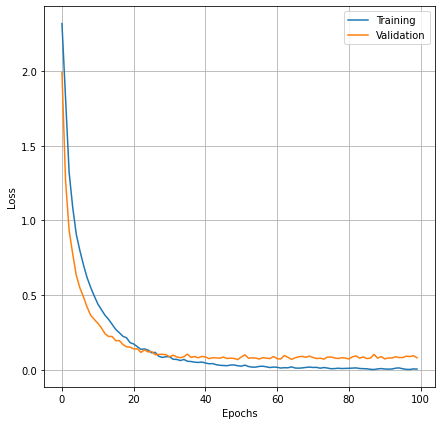

In [34]:
#Plot validation and training accuracy
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(histrainloss)#history.history['loss'])
plt.plot(hisvalloss)#history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

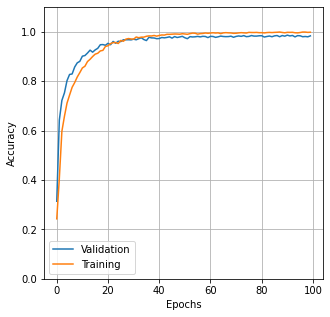

In [35]:
#Plot validation and training loss
plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(hisvalac)#history.history['accuracy'])
plt.plot(histrainac)#history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Validation','Training'])#,'Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

In [36]:
#Save all these accuracies and losses to numpy arrays
np.save('Xvalloss',hisvalloss)
np.save('Xvalac',hisvalac)
np.save('Xtrainloss',histrainloss)
np.save('Xtrainac',histrainac)

# Validation

In [20]:
# load best weights
model.load_weights("best_model_Loukiawithvalnewlastbestnoblack.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [37]:
#Save all training, validation and testing data as they are for reproducing results
np.save('Xtrain',Xtest)
np.save('ytrain',ytrain)
np.save('Xval',Xval)
np.save('yval',yval)
np.save('Xtest',Xtest)
np.save('ytest',ytest)

In [21]:
#Load test data and labels
Xtest=np.load('Xtest.npy')
ytest=np.load('ytest.npy')

In [32]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1) #Reshape test data to input them in the model for predictions
Xtest.shape

(4051, 13, 13, 30, 1)

In [33]:
ytest = np_utils.to_categorical(ytest) #Make the test labels to 1-hot encodings to compare with model predictions
ytest.shape

(4051, 14)

In [34]:
np.unique(ytest,axis=0) #To see the labels

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [31]:
Y_pred_test = model.predict(Xtest) #Model predictions
y_pred_test = np.argmax(Y_pred_test, axis=1) #Keep only the highest prediction at each pixel

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test) #Classification report for each label
print(classification)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96        86
           1       1.00      1.00      1.00        20
           2       0.98      0.97      0.98       163
           3       0.91      0.88      0.89        24
           4       0.97      0.99      0.98       420
           5       0.97      0.96      0.96        67
           6       1.00      0.98      0.99       150
           7       0.99      0.98      0.99       322
           8       0.97      0.99      0.98      1138
           9       0.98      0.97      0.97       841
          10       0.99      0.98      0.98       121
          11       0.99      0.99      0.99       146
          12       1.00      1.00      1.00       418
          13       1.00      1.00      1.00       135

    accuracy                           0.98      4051
   macro avg       0.98      0.97      0.98      4051
weighted avg       0.98      0.98      0.98      4051



In [35]:
def AA_andEachClassAccuracy(confusion_matrix): #To get total accuracy and accuracy for each class
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [33]:
Y_pred_test.shape

(4051, 14)

In [34]:
Xtest.shape

(4051, 13, 13, 30, 1)

In [35]:
ytest.shape

(4051, 14)

In [36]:
un=np.unique(ytest,axis=0)
un

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [36]:
def reports (X_test,y_test):#to get the report along with confusion matrix
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #Activate the last label only if we have black pixels
    target_names = ['Dense Urban Fabric', 'Mineral Extraction Sites', 'Non Irrigated Arable Land', 'Fruit Trees',
                    'Olive Groves', 
                    'Broad-leaved Forest', 
                    'Coniferous Forest', 
                    'Mixed Forest', 
                    'Dense Sclerophylious Vegetation', 'Sparse Schlerophyllous Vegetation',
                    'Sparcely Vegetated Areas', 'Rocks and Sand', 'Water', 'Coastal Water']#, 'Black']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [39]:
#Save the report to a file
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

(4051, 14)
(4051,)
(4051,)
127/127 [==============================] - 16s 122ms/step - loss: 0.0955 - accuracy: 0.9810


In [26]:
def Patch(data,height_index,width_index): #to be used below for showing images
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [38]:
#Load data
X=Loukia
y=LoukiaGT
print(X.shape)
print(y.shape)

(249, 945, 176)
(249, 945)


In [39]:
#Define parameters to be used below
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = 30

In [40]:
X,pca = applyPCA(X, numComponents=numComponents) #Apply PCA
X.shape

(249, 945, 30)

In [41]:
X = padWithZeros(X, PATCH_SIZE//2) #Pad image

In [43]:
np.unique(y) #Show labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int8)

In [46]:
# calculate the predicted image for all pixels
# import time
start=time.time()
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
## The following should only activated if we want to exclude predictions for pixels that we are not interested in
#         target = int(y[i,j])
#         if target == 0 :
#             continue
#         else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1
end=time.time()
print("Total time in secs")
print(end-start)

Total time in secs
9484.587587594986


In [47]:
np.save('outputs',outputs) #Save the result

In [42]:
outputs=np.load('outputs.npy') #Load these outputs

In [47]:
np.unique(outputs) #Show values of predicted labels

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14.])

In [48]:
np.unique(y) #Show values of true labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int8)

In [50]:
#These are needed only if we inserted an extra black class
outputs2=np.zeros((outputs.shape[0],outputs.shape[1]))
for i in range(outputs.shape[0]):
    for j in range(outputs.shape[1]):
        if outputs[i][j]==15:
            outputs2[i][j]=0
        else:
            outputs2[i][j]=outputs[i][j]

In [51]:
np.unique(outputs2)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14.])

In [52]:
np.save('outputs2',outputs2) #Save new outputs

In [43]:
outputs2=np.load('outputs2.npy') #Load new outputs

In [ ]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int8)

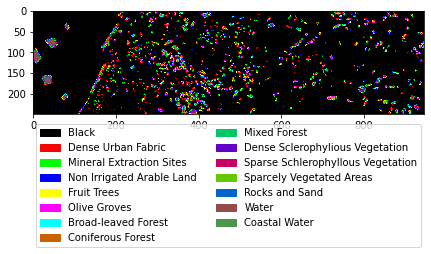

In [54]:
# Show ground-truth image
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

labelDictionary={1:'Dense Urban Fabric', 2:'Mineral Extraction Sites', 3:'Non Irrigated Arable Land', 
                 4:'Fruit Trees', 5:'Olive Groves', 6:'Broad-leaved Forest',7:'Coniferous Forest',
                 8:'Mixed Forest',9:'Dense Sclerophylious Vegetation',10:'Sparse Schlerophyllous Vegetation',
                 11:'Sparcely Vegetated Areas',12:'Rocks and Sand',13:'Water',14:'Coastal Water',0:'Black'}

labelPatches = [ patches.Patch(color=spy_colors[x]/255.,
                 label=labelDictionary[x]) for x in np.unique(y) ]

plt.legend(handles=labelPatches,ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05))

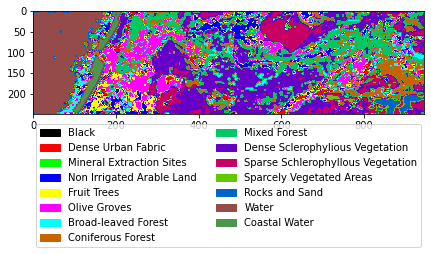

In [55]:
#Show predicted image with no black pixels
predict_image = spectral.imshow(classes = outputs2.astype(int),figsize =(7,7))

plt.legend(handles=labelPatches,ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05))

In [56]:
#Calculated predicted image without taking into account pixels that we are not interested in - Applying a mask
start=time.time()
outputs3 = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs3[i][j] = prediction+1
end=time.time()
print("Total time in secs")
print(end-start)

Total time in secs
572.0938763618469


In [57]:
np.save('outputs3',outputs3) #Save these

In [44]:
outputs3=np.load('outputs3.npy') #Load that new output

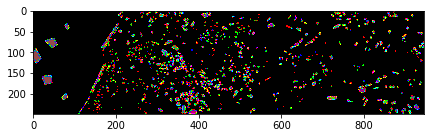

In [58]:
predict_image = spectral.imshow(classes = outputs3.astype(int),figsize =(7,7)) #Show that image

In [59]:
#Save these three images
spectral.save_rgb("predictionsLoukia.jpg", outputs2.astype(int), colors=spectral.spy_colors)
spectral.save_rgb("predictionsLoukiatarget.jpg",y.astype(int), colors=spectral.spy_colors)
spectral.save_rgb("predictionsLoukiawithoutzeros.jpg", outputs3.astype(int), colors=spectral.spy_colors)

Second training image does not work! Next section can be ommited

In [51]:
X=Dioni
y=DioniGT
K = 30 #if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)
X.shape

In [ ]:
#Run out of memory since bigger spatial dimensions
X, y = createImageCubes(X, y, windowSize=windowSize)
X.shape, y.shape

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape
ytest = np_utils.to_categorical(ytest)
ytest.shape

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

In [ ]:
X=Dioni
y=DioniGT
height2 = y.shape[0]
width2 = y.shape[1]
X,pca = applyPCA(X, numComponents=numComponents)
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
import time
start=time.time()
outputstr = np.zeros((height2,width2))
for i in range(height2):
    for j in range(width2):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputstr[i][j] = prediction+1
end=time.time()
print("Total time in secs")
print(end-start)

In [ ]:
outputstrnew=np.zeros((outputstr.shape[0],outputstr.shape[1]))
for i in range(outputstr.shape[0]):
    for j in range(outputstr.shape[1]):
        if outputstr[i][j]==15:
            outputstrnew[i][j]=0
        else:
            outputstrnew[i][j]=outputstr[i][j]

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))


In [ ]:
predict_image = spectral.imshow(classes = outputstr.astype(int),figsize =(7,7))

In [ ]:
predict_image = spectral.imshow(classes = outputstrnew.astype(int),figsize =(7,7))

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)

Validation Images

In [22]:
Erato=tifffile.imread('/content/drive/My Drive/col/HyRANK_satellite/HyRANK_satellite/ValidationSet/Erato.tif')
Nefeli=tifffile.imread('/content/drive/My Drive/col/HyRANK_satellite/HyRANK_satellite/ValidationSet/Nefeli.tif')
Kirki=tifffile.imread('/content/drive/My Drive/col/HyRANK_satellite/HyRANK_satellite/ValidationSet/Kirki.tif')

Predicted Image for **Erato**

In [47]:
X=Erato
K = 30 
X,pca = applyPCA(X,numComponents=K)

In [48]:
PATCH_SIZE=windowSize
height = X.shape[0]
width = X.shape[1]
X = padWithZeros(X, PATCH_SIZE//2)
X.shape

(253, 1644, 30)

In [49]:
# calculate the predicted image
start=time.time()
outputs4 = np.zeros((height,width))
for i in range(height):
    for j in range(width):
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs4[i][j] = prediction+1
end=time.time()
print("Total time in secs")
print(end-start)

Total time in secs
17258.55034828186


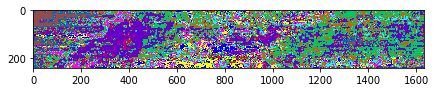

In [62]:
#Show predicted image
predict_image = spectral.imshow(classes = outputs4.astype(int),figsize =(7,7))

In [51]:
np.save('outputs4',outputs4)

In [61]:
outputs4=np.load('outputs4.npy')

In [63]:
spectral.save_rgb("predictionsErato.jpg", outputs4.astype(int), colors=spectral.spy_colors)

In [ ]:
#Only if we are interested in black pixels
outputs5=np.zeros((outputs4.shape[0],outputs4.shape[1]))
for i in range(outputs4.shape[0]):
    for j in range(outputs4.shape[1]):
        if outputs4[i][j]==15:
            outputs5[i][j]=0
        else:
            outputs5[i][j]=outputs4[i][j]

In [ ]:
#Show images with black pixels
predict_image = spectral.imshow(classes = outputs5.astype(int),figsize =(7,7))

Predicted Image for **Nefeli** - Same code as before

In [64]:
X=Nefeli
K = 30 
X,pca = applyPCA(X,numComponents=K)

In [65]:
PATCH_SIZE=windowSize
height = X.shape[0]
width = X.shape[1]
X = padWithZeros(X, PATCH_SIZE//2)
X.shape

(261, 784, 30)

In [66]:
# calculate the predicted image
start=time.time()
outputs6 = np.zeros((height,width))
for i in range(height):
    for j in range(width):
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs6[i][j] = prediction+1
end=time.time()
print("Total time in secs")
print(end-start)

Total time in secs
8680.749790906906


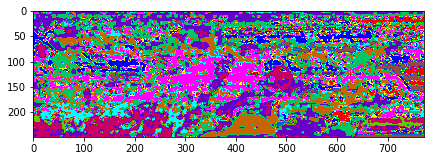

In [67]:
#Show predicted image
predict_image = spectral.imshow(classes = outputs6.astype(int),figsize =(7,7))

In [68]:
np.save('outputs6',outputs6)

In [69]:
spectral.save_rgb("predictionsNefeli.jpg", outputs6.astype(int), colors=spectral.spy_colors)

In [ ]:
#Only if we are interested in black pixels
outputs7=np.zeros((outputs6.shape[0],outputs6.shape[1]))
for i in range(outputs6.shape[0]):
    for j in range(outputs6.shape[1]):
        if outputs6[i][j]==15:
            outputs7[i][j]=0
        else:
            outputs7[i][j]=outputs6[i][j]

In [ ]:
#Show images with black pixels
predict_image = spectral.imshow(classes = outputs7.astype(int),figsize =(7,7))

Predicted Image for **Kirki** - Same code as before

In [23]:
X=Kirki
K = 30 
X,pca = applyPCA(X,numComponents=K)

In [24]:
PATCH_SIZE=windowSize
height = X.shape[0]
width = X.shape[1]
X = padWithZeros(X, PATCH_SIZE//2)
X.shape

(257, 1638, 30)

In [ ]:
# calculate the predicted image
start=time.time()
outputs8 = np.zeros((height,width))
for i in range(height):
    for j in range(width):
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs8[i][j] = prediction+1
end=time.time()
print("Total time in secs")
print(end-start)

In [ ]:
#Show predicted image
predict_image = spectral.imshow(classes = outputs8.astype(int),figsize =(7,7))

In [ ]:
np.save('outputs8',outputs8)

In [ ]:
spectral.save_rgb("predictionsKirki.jpg", outputs8.astype(int), colors=spectral.spy_colors)

In [ ]:
#Only if we are interested in black pixels
outputs9=np.zeros((outputs8.shape[0],outputs8.shape[1]))
for i in range(outputs8.shape[0]):
    for j in range(outputs8.shape[1]):
        if outputs8[i][j]==15:
            outputs9[i][j]=0
        else:
            outputs9[i][j]=outputs8[i][j]

In [ ]:
#Show images with black pixels
predict_image = spectral.imshow(classes = outputs9.astype(int),figsize =(7,7))